In [1]:
import re, pickle, os, string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np 
import pandas as pd 
import nltk
import string
import spacy
from nltk.corpus import stopwords
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
train_data = None
test_data = None

def load_data():
    global train_data, test_data
    train_data = pd.read_csv('split_data_original.txt', delimiter="\t", header=None)
    test_data = pd.read_csv('test_tweets_unlabeled.txt', delimiter="\t", header = None)
    
load_data()
train_data.columns = ['Tweet', 'label']
print(train_data)

                                                 Tweet  label
0                                                Tweet  label
1       @handle Let's try and catch up live next week!   8746
2    Going to watch Grey's on the big screen - Thur...   8746
3    @handle My pleasure Patrick....hope you are well!   8746
4    @handle Hi there! Been traveling a lot and lot...   8746
5    RT @handle Looking to Drink Clean & Go Green? ...   8746
6    RT @handle: Ft. Hood officials confirm the 2 o...   8746
7    RT @handle: Mickey Mouse is Getting a Make Ove...   8746
8             @handle How did u get the invite Justin?   8746
9    @handle I think I am still a good friend of he...   8746
10   @handle I remember! I am fine - how are u? Wha...   8746
11      @handle That's great - good for the coach!!!!!   8746
12   @handle I don't want to picture u sitting on i...   8746
13   @handle D- Thanks for the RTs....are you going...   8746
14            @handle Grrr....you must be going crazy!   8746
15   @ha

In [3]:
def load_pickle(filepath):
    documents_f = open(filepath, 'rb')
    file = pickle.load(documents_f)
    documents_f.close()
    
    return file

def save_pickle(data, filepath):
    save_documents = open(filepath, 'wb')
    pickle.dump(data, save_documents)
    save_documents.close()

In [4]:
stp = [word for word in list(stopwords.words('english') + [ "'s", "'m", "ca"])
        if word not in ["no", "not"] and word.rfind("n't") == -1]

class PreProcessor(object):
    '''Pre-processor which cleans text, lemmatises, removes stop words and punctuation, 
    returns df of processed text.'''

    def __init__(self):
        self._stopWordList = stp
        self._punct_removal = list(string.punctuation)
        self.sid = SentimentIntensityAnalyzer()


    def remove_url(self, text):
        result = re.sub(r"http\S+", "", text)
        return result
    
    def check_url(self, text):
        url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text) 
        if len(url) != 0:
            return True
        return False
    
    def unique_words(self, words):
        word_count = len(words)
        unique_count = len(set(words))
        if word_count!=0:
            return unique_count / word_count
        return 0
    
    def find_tags(self, text):
        from nltk.tag import StanfordNERTagger
        from nltk import word_tokenize
        
        jar = '/Users/belle/Downloads/stanford-ner/stanford-ner.jar'
        model = '/Users/belle/Downloads/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz'
        
        st = StanfordNERTagger(model, jar, encoding='utf8')

        for i in range(1):
            classified_text = st.tag(word_tokenize(text))
            print(classified_text)
        return classified_text
   
    def transform_text(self, data):
        
        '''applies the clean and tokenise methods to the texts, 
        encodes the target variable to numerical. 
        Option to set pickle to True to save clean df'''
        no_punct_translator=str.maketrans('','',string.punctuation)
        
        data['words'] = data['Tweet'].apply(lambda row: self.remove_url(str(row))).apply(lambda t: nltk.word_tokenize(t.translate(no_punct_translator).lower()))
        data['URL'] = data['Tweet'].apply(lambda row: self.check_url(str(row)))
        data['word_count'] = data['words'].apply(lambda words: len(words))
        data['sentence_length'] = data['words'].apply(lambda w: sum(map(len, w)))
        data['text_length'] = data['Tweet'].apply(lambda t: len(str(t)))
        data['sentiment'] = data['Tweet'].apply(lambda t: self.sid.polarity_scores(t)['compound'])
        data['punctuation_per_tweet'] = data['Tweet'].apply(lambda t: len(list(filter(lambda c: c in t, string.punctuation)))) / data['text_length']
        data['unique_ratio'] = data['words'].apply(lambda row: self.unique_words(row))
        data['avg_word_length'] = data['words'].apply(lambda words: sum(map(len, words)) / len(words) if len(words)!=0 else 0)
        return data
    
    def transform_text1(self, data):
        no_punct_translator=str.maketrans('','',string.punctuation)
        data['words'] = data['Tweet'].apply(lambda row: self.remove_url(str(row))).apply(lambda t: nltk.word_tokenize(t.translate(no_punct_translator).lower()))
        #print(str(data['words']))
        
        ### tokenized
        tokenizedWord = sum(data['words'],[])
        #print(tokenizedWord)
        
        ### remove stop word
        rmStopword = [w for w in tokenizedWord if not w in stp]
        #print("rmStopword ="+str(rmStopword))
        
        ### connecting all filtered words
        all_words = ' '.join([text for text in rmStopword])
        #print("all_words ="+all_words)
        
        all_list= [' '.join([text for text in rmStopword])]
        
        ### create the word cloud
        from wordcloud import WordCloud
        wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()    
        
        ### count the word frequency
        a = nltk.FreqDist(rmStopword)
        d = pd.DataFrame({"Word": list(a.keys()),
                          "Count": list(a.values())})
        # selecting top 10 most frequent hashtags     
        d = d.nlargest(columns="Count", n = 20) 
        plt.figure(figsize=(16,5))
        ax = sns.barplot(data=d, x= "Word", y = "Count")
        ax.set(ylabel = "Count")
        plt.show()
             
        ### bag-of-words feature matrix
        from sklearn.feature_extraction.text import CountVectorizer
        bow_vectorizer = CountVectorizer()
        bow = bow_vectorizer.fit_transform(all_list) #[:224]
        bowArray = bow.toarray()
      
        print(bow.toarray())
        #print (bow_vectorizer.vocabulary_)
        #print("bow = " + bow)
        
        #print ("num of features = " + len(bow_vectorizer.vocabulary_))
        #print("bow")
        
 
        ### TF-IDF
        from sklearn.feature_extraction.text import TfidfVectorizer
        tfidf_vectorizer = TfidfVectorizer(all_list)
        # TF-IDF feature matrix
        tfidf = tfidf_vectorizer.fit_transform(rmStopword)
        #print(tfidf)
        


        return data

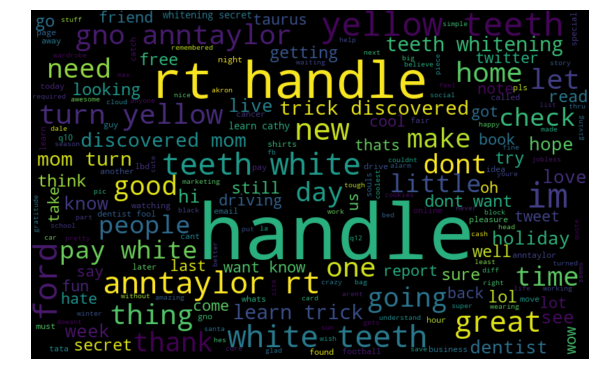

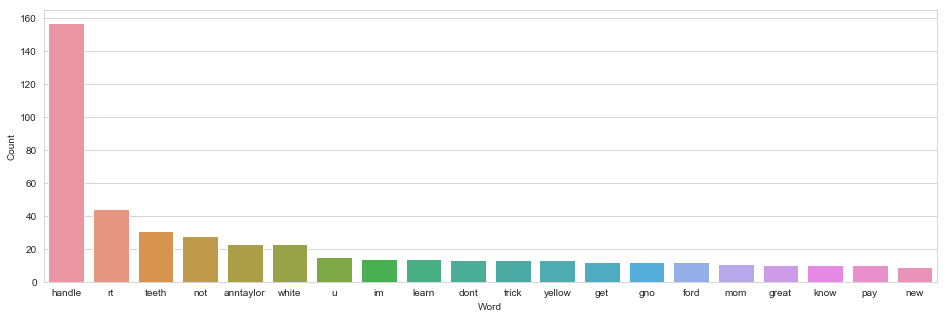

[[  3   1   1   1   1   1   3   1   1   1   2   1   1   1   1   1   1   1
    1   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1
    2   1   2   2   2   1   1   1  23   1   3   2   1   1   1   1   1   2
    1   1   1   1   1   1   1   1   1   1   1   1   2   3   2   1   4   1
    1   1   1   1   1   1   1   2   1   2   1   1   1   1   2   2   1   1
    2   1   1   2   1   1   1   1   1   1   3   1   1   1   1   1   2   1
    1   2   1   1   1   1   3   1   1   1   1   3   1   3   3   1   2   2
    1   1   1   2   1   1   1   3   1   4   1   1   1   1   1   1   1   7
    1   1   1   1   1   1   1   1   1   1   1   1   2   1   1   1   2   1
    1   1   1   1   4   1   1   1   1   1   1   2   1   1   1   2   4   1
    2   3   2   2   1   1   2   1   1   2   1   1   1   2   1   1   1   1
    1   1   2   1   1   2   1   1   7   1   1   1   2   1   1   1   1   5
    4   1   1   1   1   1   2   1   1   7   1   1   1   1   1   2   2   1
   13   1   1   1   1   1   3   4   1 

,Tweet,label,words
0,Tweet,label,[tweet]
1,@handle Let's try and catch up live next week!,8746,"[handle, lets, try, and, catch, up, live, next..."
2,Going to watch Grey's on the big screen - Thur...,8746,"[going, to, watch, greys, on, the, big, screen..."
3,@handle My pleasure Patrick....hope you are well!,8746,"[handle, my, pleasure, patrickhope, you, are, ..."
4,@handle Hi there! Been traveling a lot and lot...,8746,"[handle, hi, there, been, traveling, a, lot, a..."


In [5]:
processor = PreProcessor()
clean_train = processor.transform_text1(train_data)
clean_train.head()